In this notebook, we will be doing learn a policy for navigating this a grid using reinforcement learning.  We’ll imagine the decision maker in this world is a robot in a field. The field is a grid of 50 locations arranged in  5 rows by 10 columns. There are also five different categories of locations. You can think of the categories as being types of terrain --- say, gravel, grass, shallow water, mud, and asphalt. The robot can tell what category each location is. We can allocate different rewards to each category and then see how the robot navigates in response.


Below we import some of the libraries we'll be using and build our grid for navigation, `grid_map`. The grid will have `nrows = 5` rows and `ncols = 10` columns.  The cells of the grid can grid will be one of `ncats = 5` possible values, from 0 to 4.

In [ ]:
!pip install keras=='2.3.1'
import numpy as np
import keras.backend as K
 
# the empty grid
nrows = 5
ncols = 10
 
# ncats is the number of state categories
ncats = 5
 
# map state categories to states
# want m s.t. r %*% m = reward function
# first, just a map of the indexes
grid_map = np.array([ [0,0,0,0,0,2,0,0,1,0],
                 [0,1,0,0,0,2,0,0,0,0],
                 [0,0,0,0,0,2,1,3,0,0],
                 [0,0,0,1,0,2,0,3,0,0],
                 [0,0,0,0,0,2,0,3,0,4]])

Using TensorFlow backend.


Next we'll visualize the map, assigning colors in the order of the `colors` list with `seaborn`:
0. white
1. blue
2. orange
3. yellow
4. green

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


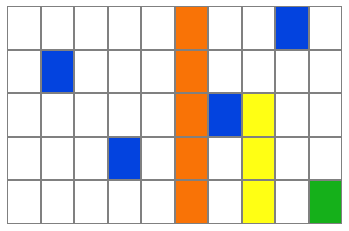

In [ ]:
import seaborn as sns
 
colors = ["white", "blue", "orange", "yellow", "green"]
 
sns.heatmap(grid_map, cmap=sns.xkcd_palette(colors), yticklabels=False, xticklabels=False,
            annot=False, cbar = False, annot_kws={"size": 30}, linewidths=1, linecolor="gray")

We can assign reward values, `r`, to each of the terrain categories.

We will additionally binarize `grid_map`, adding an additional dimension representing the value in the cell to make `matmap`.  Values in `matmap` equal 1 if the value of row and column of that cell in `grid_map` equal is the value of the third dimension of the cell.  

The `clip` function keeps the current location in the grid to be within the size of the grid. 

We define five actions, `acts`, in terms of how each one changes the robot’s row and column. The first decreases the row by 1 and leaves the column unchanged. That corresponds to moving UP in the grid. The other actions correspond to moving right, down, left, and staying in place.

We will also build a transition matrix, `mattrans`, that describes the transition. This matrix represents the probability that the given action will cause a one-step transition between any given pair of locationd. We fill in this matrix by looping through all the actions. For each action, we: 

  - enumerate all possible starting rows and columns,  `i1` and `j1`
  - define `i-next` and `j-next` to encode the location that results from adding an action’s row and column increments to the current row and column, then applying `clip` to keep the results in the range of the grid
  - loop through all the possible next locations, row `i2` and column `j2`
  - fill in the transition matrix with a 1 if the new `i2 == i-next` and `j2==j-next`



In [ ]:
# r is the rewards for the different location categories
r = np.array([0, -1, -1, -1, 10])
 
matmap = np.zeros((nrows,ncols,ncats))
for i in range(nrows):
  for j in range(ncols):
    for k in range(ncats):
      matmap[i,j,k] = 0+(grid_map[i,j] == k)
def clip(v,min,max):
  if v < min: v = min
  if v > max-1: v = max-1
  return(v)
 
acts = [(-1,0), (0,1), (1,0), (0,-1), (0,0)]
nacts = len(acts)
mattrans = np.zeros((nacts,nrows*ncols,nrows*ncols))
for acti in range(nacts):
  act = acts[acti]
  for i1 in range(nrows):
    for j1 in range(ncols):
      inext = clip(i1 + act[0],0,nrows)
      jnext = clip(j1 + act[1],0,ncols)
      for i2 in range(nrows):
        for j2 in range(ncols):
          mattrans[acti,i1*ncols+j1,i2*ncols+j2] = 0+((i2 == inext) and (j2 == jnext))

We make a keras variable `rk` for the category rewards. Then, we take `matmap` and compute the dot product of `matmap` with `rk` to map each location to its reward value.

We use these values as the starting point for our reinforcement-learning process, assigning it to `v`, the robot’s estimated best value for being in each location.

We calculate how much to discount future reward compared to current reward with the parameter `gamma`.  When `gamma = 0.9`, a reward retains 90 percent of its value one time step later. When `gamma` is close to 1, the robot cares a lot about making choices that will eventually lead to high reward. When `gamma` is close to zero, the robot only cares about short term gain, even if that means sacrificing opportunities for additional rewards later.

We also define `beta`, which indicates how "carefully" the robot will choose among closely valued actions. High values of `beta` cause the robot to reliably choose the highest valued actions and  values close to zero result in the robot being more “careless” and choosing randomly among the available options. `beta = 10` results in moderately careful reward maximizing choices.

In [ ]:
rk = K.placeholder(len(r))
rfk = K.dot(K.constant(matmap),K.reshape(rk,(-1,1)))
rffk = K.reshape(rfk,(-1,1))
 
v = K.reshape(rfk,(-1,1))
gamma = 0.90
beta = 10.0

The robot will look 50 steps into the future when it makes decisions. That’s a reasonable choice as the robot can make it across the entire grid world in 15 steps.

For each step of looking into the future, the robot considers each of the five action calucates an estimate of the value of taking each action.  Each value of `q0`, `q1`, `q2`, `q3`, and `q4` corresponds to the estimated value of actions 0 to 4, by multipling the transition matrix for an action by the value estimate, `v`.

`Q` brings all those values together into one array. The array has one row for each location and one column for each action.

`pi` represents the robot’s assigned probability to each action in each location. The probability of the robot taking an action in a location is determined by how much reward `Q` predicts it will get from taking that action in that location. The higher the predicted reward, the more likely the robot is to take that action. `beta` controls how the strength of the relationship between reward and probability.

The value `v` reflects how good it is to be in each location looking ahead one additional step. The planner multiplies the action matrix times the values, discounted them by gamma, and then added in the reward for being in the current state.

In [ ]:
for _ in range(50):
  q0 = K.dot(K.constant(mattrans[0]),v)
  q1 = K.dot(K.constant(mattrans[1]),v)
  q2 = K.dot(K.constant(mattrans[2]),v)
  q3 = K.dot(K.constant(mattrans[3]),v)
  q4 = K.dot(K.constant(mattrans[4]),v)
  Q = K.concatenate([q0,q1,q2,q3,q4])
  pi = K.softmax(beta*Q)
  v = rffk + gamma * K.reshape(K.sum(Q * pi,axis=1),(-1,1))

We define the `planner` function in terms of the reward `rk`, our policy `pi`, and our valeus for each action `Q`, we then run the planner to get our final values of the policy `piout` and values `Qout`.

In [ ]:
planner = K.function([rk], [pi, Q])

r = np.array([0, -1, -1, -1, 10])
piout, Qout = planner([r])

We also define the function `plotpolicy` which uses `findpol` to visualize the policy's learned trajectories given the grid setup.

In [ ]:
def findpol(grid,pi,r,c):
  if grid[r][c] != 6: return
  maxprob = max(pi[r*ncols+c,:])
  a = 6
  for ana in range(5):
    if pi[r*ncols+c, ana] == maxprob: a = ana
  grid[r][c] = a
  r += acts[a][0]
  c += acts[a][1]
  findpol(grid,pi,r,c)

def plotpolicy(pi):
  grid = []
  for r in range(nrows):
    line = []
    for c in range(ncols):
      line += [6]
    grid += [line]
  findpol(grid,pi,0,0)
  for r in range(nrows):
    line = ""
    for c in range(ncols):
      line += '^>v<x? '[grid[r][c]]
    print(line)

Let's assign different values to the reward `r` and plot the trajectory.  The arrow symbols, `<>^v` indcate the direction of the movement and `x` means motion has stopped.  In this array, the highest rewards are associated with green.

In [ ]:
r = np.array([0, -1, -1, -1, 10])
piout, Qout = planner([r])
plotpolicy(piout)

>>>v      
   >>>>>v 
        v 
        v 
        >x


In this example, blue, orange, and yellow rewards are very negative.

In [ ]:
r = np.array([0, -10, -10, -10, 1])
piout, Qout = planner([r])
plotpolicy(piout)

x         
          
          
          
          


Here, we put a negative reward 

In [ ]:
r = np.array([-1, 0, 0, 0, 1])
piout, Qout = planner([r])
plotpolicy(piout)

v         
>>>>>v    
     >>v  
       v  
       >>x


Here, we learn a `loss` function based on a trajectory of actions `trajacts`.

We convert this sequence of actions into a sequence of locations, `trajcoords`, using `reduce`.

In [ ]:
from functools import reduce
 
#  0      1     2     3     4
# up, right, down, left, stay
 
trajacts = [1,1,2,2,2,2,1,1,1,1,1,1,1,4,4,4,4,4,4,4]
 
trajcoords = reduce((lambda seq, a: seq+[[seq[len(seq)-1][0] + acts[a][0], seq[len(seq)-1][1] + acts[a][1]]]), trajacts, [[0,0]])

To compute the loss, we run through this sequence of actions and look at the policy `pi`. We find the probability assigned to the the action, sequence pair at timestep `i` and take the negative log of that value and add it to the `loss`.

In [ ]:
loss = 0
for i in range(len(trajacts)):
  acti = trajacts[i]
  state = trajcoords[i]
  loss += -K.log(pi[state[0]*ncols+state[1]][acti])

We use gradient descent to search for a reward function that produces low loss. We pick a `learning_rate` and randomly initialize our values for the reward `r`.

We compute the gradient of the loss with respect to the rewards, which we store in the variable, `grads`. Next, we create a keras function that takes the rewards, `rk` as input and produces the `loss` and the `grads` as output, `iterate`.

Over 5000 steps, we will update `r` based in the `learning_rate` and `grads_value` of the gradient.  We also will print our `loss_value` every 100 steps.

In [ ]:
learning_rate = 0.001
 
r = np.random.rand(5)*2-1
 
grads = K.gradients(loss, rk)[0]
iterate = K.function([rk], [loss, grads])
 
for iter in range(5000):
  loss_value, grads_value = iterate([r])
  r -= learning_rate * grads_value
  if iter % 100 == 0: print(loss_value, r)

43.19532 [ 0.0152681  -0.72682635 -0.94306783  0.5893426   0.46266321]
10.742431 [ 0.00246819 -0.72648347 -0.94292318  0.12751389  0.93681501]
10.546041 [-0.04133214 -0.72722192 -0.93835732  0.05784059  1.04647657]
10.474117 [-0.06903074 -0.72896468 -0.9359211   0.0169078   1.11440674]
10.4364195 [-0.08887663 -0.73154532 -0.93438346 -0.01208641  1.16428496]
10.413028 [-0.1040377  -0.73482933 -0.93326806 -0.03449754  1.20402726]
10.396965 [-0.11606262 -0.73869352 -0.93234188 -0.05276248  1.23725967]
10.385152 [-0.12582631 -0.74302496 -0.93146867 -0.06822171  1.26594458]
10.376006 [-0.13387576 -0.74772223 -0.93056114 -0.08171799  1.29127647]
10.368637 [-0.14054984 -0.75269629 -0.92955186 -0.0938303   1.31403669]
10.362515 [-0.14607916 -0.75786988 -0.92838851 -0.10500122  1.33476262]
10.357225 [-0.15060213 -0.76317631 -0.92702429 -0.11560164  1.35383346]
10.352555 [-0.1541712  -0.76855717 -0.9254146  -0.125969    1.37154203]
10.34831 [-0.15679199 -0.77395887 -0.92352108 -0.1364323   1.388